In [1]:
import numpy as np
import matplotlib.pyplot as plt

from vdyn.tracks.track import CenterlineTrack
from vdyn.models.bicycle_kinematic import KinematicBicycle
from vdyn.utils.frenet import track_errors
from vdyn.utils.speed_profile import curvature_speed_profile, v_ref_lookup
from vdyn.controllers.stanley import stanley_delta

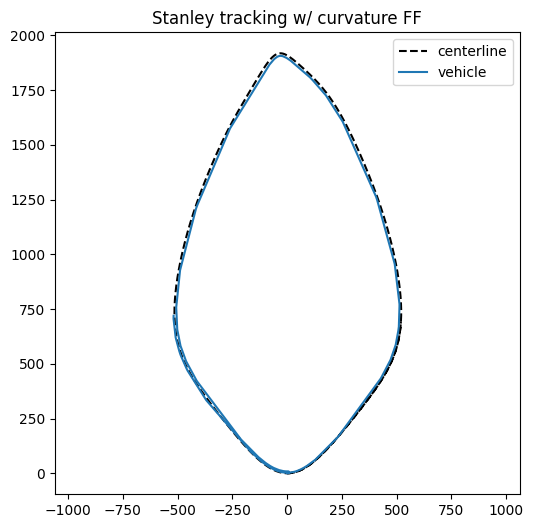

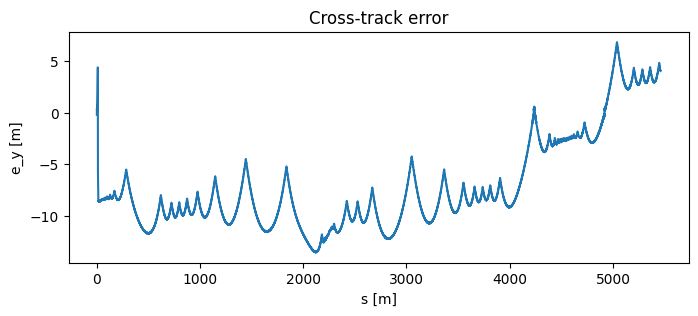

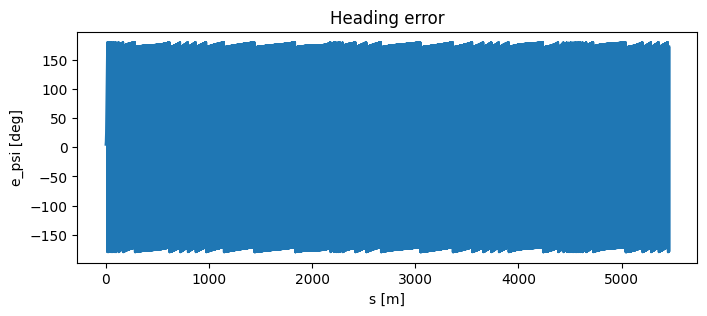

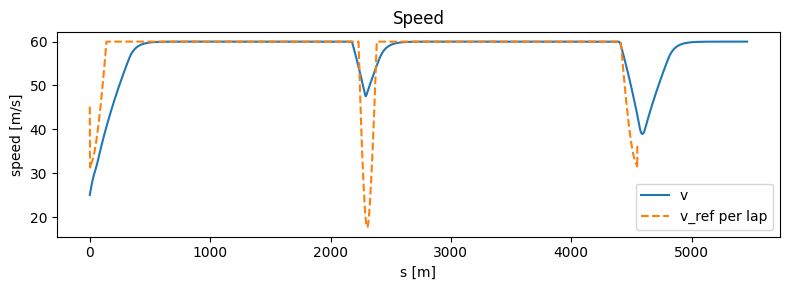

In [2]:
trk = CenterlineTrack.from_csv("../data/closed_gp_circuit.csv") 

# --- Vehicle / control params ---
car = KinematicBicycle(wheelbase_m=2.8)
dt       = 0.01
k_gain   = 1.0
ks       = 1e-2
deltaMax = np.deg2rad(35)
a_lat_max = 8.0        # cornering capability
v_cap     = 60.0       # straight-line cap
k_v       = 1.0        # longitudinal P gain
ax_min, ax_max = -6.0, 4.0

# --- Precompute v_ref(s) ---
Sgrid, v_ref_s = curvature_speed_profile(trk, a_lat_max=a_lat_max, v_cap=v_cap, n=4000)

def v_ref_at(s):  # convenience
    return v_ref_lookup(s, Sgrid, v_ref_s, trk.L)

# --- Init state (slightly perturbed) ---
x, y = trk.sample_xy(0.0)
psi  = trk.sample_psi(0.0) + np.deg2rad(5.0)
x   += 2.0
v    = 25.0
s_unwrapped = 0.0
goal_s = 1.2 * trk.L   # run ~1.2 laps

log = {k: [] for k in ["x","y","psi","v","s","ey","epsi","delta","ax"]}

while s_unwrapped < goal_s:
    # Frenet errors
    ey, epsi, s_star = track_errors(x, y, psi, trk)

    # Feed-forward from curvature at nearest point
    kappa_ff = trk.sample_kappa(s_star)
    delta_ff = np.arctan(car.wheelbase_m * kappa_ff)

    # Stanley steering
    delta = stanley_delta(ey, epsi, v, k_gain=k_gain, ks=ks,
                          delta_ff=delta_ff, limits=(-deltaMax, deltaMax))

    # Longitudinal control to v_ref(s)
    v_tgt = v_ref_at(s_star)
    ax = np.clip(k_v * (v_tgt - v), ax_min, ax_max)

    # Integrate vehicle
    x, y, psi, v = car.step(x, y, psi, v, ax, delta, dt)
    s_unwrapped += v * dt

    # Log
    log["x"].append(x); log["y"].append(y); log["psi"].append(psi)
    log["v"].append(v); log["s"].append(s_unwrapped)
    log["ey"].append(ey); log["epsi"].append(epsi)
    log["delta"].append(delta); log["ax"].append(ax)

# --- Draw centerline for same distance with seam breaks ---
Sdraw = np.linspace(0.0, s_unwrapped, 1400, endpoint=False)
CX, CY = [], []
for s in Sdraw:
    if (s % trk.L) < 1e-3 and s > 1e-3:
        CX.append(np.nan); CY.append(np.nan)
    gx, gy = trk.sample_xy(s)
    CX.append(gx); CY.append(gy)

# --- Plots ---
plt.figure(figsize=(6,6))
plt.plot(CX, CY, 'k--', label='centerline')
plt.plot(log["x"], log["y"], label='vehicle')
plt.axis('equal'); plt.legend(); plt.title("Stanley tracking w/ curvature FF")

plt.figure(figsize=(8,3))
plt.plot(log["s"], log["ey"])
plt.ylabel("e_y [m]"); plt.xlabel("s [m]"); plt.title("Cross-track error")

plt.figure(figsize=(8,3))
plt.plot(log["s"], np.rad2deg(log["epsi"]))
plt.ylabel("e_psi [deg]"); plt.xlabel("s [m]"); plt.title("Heading error")

plt.figure(figsize=(8,3))
plt.plot(log["s"], log["v"], label='v')
plt.plot(Sgrid, v_ref_s, '--', label='v_ref per lap')
plt.ylabel("speed [m/s]"); plt.xlabel("s [m]"); plt.title("Speed"); plt.legend()
plt.tight_layout()